In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


## Plotting GRO-seq metagene analysis data from different time points and different subsets of genes (those with 5fC, etc...)



First define helping functions 

In [2]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [3]:
def sg_smooth(x, window_len, order=0):
    """Do SG filtering"""
    return(savgol_filter(x, window_len, order, mode="mirror"))

In [4]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

Average fwd and reverse strand, smooth the profiles, locate the midpoint of the decaying wave 

In [5]:
def pol2_midpoint(fn_ko_f, fn_ko_r, list_time=["t10", "t20", "t30"]):
    """Return smoothed profiles and location of pol2 midpoint"""

    data_ko_f = pd.read_table(fn_ko_f)
    # get a DataFrame for both wt and ko
    df_ko_f = data_ko_f.T 
    df_ko_f.columns = df_ko_f.iloc[0].values
    ####
    data_ko_r = pd.read_table(fn_ko_r)
    df_ko_r = data_ko_r.T 
    df_ko_r.columns = df_ko_r.iloc[0].values
    
    
    sg_window = 51
    sg_pol = 0
    
    # make sure the list of times include the steady state and t0
    # we need steady for normalization, and t0 for lower bounds
    # to extract the mid points
    l_w = list_time
        
    # Average both fwd and rev strands
    df_s = pd.DataFrame()
    for l in l_w + ["t0", "std"]:
        df_s["ko_"+l] = 0.5*(df_ko_r[l+"_r"][3:] + df_ko_f[l+"_f"][3:])

    sm_ko = []
    # find the midpoint 
    # we assume that the max is 1, given by the std/std
    # We decided against plotting it, to make the figure easier on the eye, 
    # but we do have it just in case
    ko = sg_smooth(df_s["ko_t0"]/df_s["ko_std"], sg_window, sg_pol)

    sm_ko.append(ko)
    d = 0.5*(1.0-ko.mean())
    low_wt = ko.mean()
    half_p = low_wt + d

    # smooth data, find midpoints 
    pos_ko = []
    for l in l_w:

        ko = sg_smooth(df_s["ko_" + l]/df_s["ko_std"], sg_window, sg_pol)
        place_ko = list(np.where(ko==find_nearest(ko, half_p))[0])[0]
        pos_ko.append((place_ko))
        sm_ko.append(ko)


    ko = sg_smooth(df_s["ko_std"], sg_window, sg_pol)
    sm_ko.append(ko)
    d_return = {"sm_ko": sm_ko, "pos_ko": pos_ko}
    return(d_return)

Function to plot the profiles

In [6]:
def plot_profiles(d_res, time, names, h3_positions, figw=10.5, figh=13.5, figname="all_groseq.pdf"):
    """Make the figure"""
    
    # As many plots ad number of conditions, plus one for the h3_5fC x-link coverarge
    num_plots = len(d_res)+1
    f, axis = plt.subplots(num_plots, 1, figsize=(cm2inch(figw, figh)), sharex=True, dpi=300)
    f.subplots_adjust(hspace=0.03)

    if num_plots == 1:
        axs = [axis]
    else:
        axs = axis
    c=0
    for p, ax, name in zip(d_res, axs[:-1], names):
        c +=1
        for ko,  t in zip(p["sm_ko"], time):
            if t != "std":
                ax.plot(0.1*np.arange(-100, len(ko[:-(200+100)])), ko[100:-100], label=t+" min")
                
        ax.axhline(y=1, linestyle="dotted", lw=1, color="gray")   

        ax.set_ylim(0, 1.7)
        if c==1:
            ax.legend(ncol=4, fontsize=6, loc="upper right").get_frame().set_linewidth(0.0)

        ax.text(-15, 1.3, name, size=14)
        if c==2:
            ax.set_ylabel("Normalized GRO-seq signal")
            
    # Now the h3 positions 
    axs[-1].plot(5*np.arange(-2,len(h3_positions[:-2])), h3_positions, label="Crosslinked 5fC", color="black")
    axs[-1].legend(ncol=4, fontsize=6, loc="upper right").get_frame().set_linewidth(0.0)
    axs[-1].set_ylabel("Coverage (RPKM)")
    
    plt.xlabel("Distance from TSS (kb)")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.savefig(figname, bbox_inches='tight')
    plt.show()

For each set, get the smoothed curves and their midpoints.
Read in also the h3-5fC profile arount the TSS and smooth it a little

In [29]:
All = pol2_midpoint("metagene_tss_f_ko_all.dat", "metagene_tss_r_ko_all.dat", 
                    list_time=["t10", "t20","t30"])
fC = pol2_midpoint("metagene_tss_f_ko_5fC.dat", "metagene_tss_r_ko_5fC.dat",
                   list_time=["t10", "t20","t30"])
caC = pol2_midpoint("metagene_tss_f_ko_5caC.dat", "metagene_tss_r_ko_5caC.dat", 
                    list_time=["t10", "t20","t30"])
fC_nocaC = pol2_midpoint("metagene_tss_f_ko_5fC_no5caC.dat", "metagene_tss_r_ko_5fC_no5caC.dat", 
                         list_time=["t10", "t20", "t30"])
caC_nofC = pol2_midpoint("metagene_tss_f_ko_5caC_no5fC.dat", "metagene_tss_r_ko_5caC_no5fC.dat", 
                         list_time=["t10", "t20","t30"])
nofC_nocaC = pol2_midpoint("metagene_tss_f_ko_no5fC_no5caC.dat", "metagene_tss_r_ko_no5fC_no5caC.dat", 
                           list_time=["t10", "t20","t30"])
h3_ov5fC = pol2_midpoint("metagene_tss_f_ko_union_h3_1_2_overlap5fC.dat", 
                         "metagene_tss_r_ko_union_h3_1_2_overlap5fC.dat", 
                         list_time=["t10", "t20", "t30"])
h3 = pol2_midpoint("metagene_tss_f_ko_union_h3_1_2.dat", 
                   "metagene_tss_r_ko_union_h3_1_2.dat", 
                   list_time=["t10", "t20", "t30"])

# the H3-5fC coverage centered at the TSS, smoothed
data_h3_overlap5f = pd.read_table("metagene_h3_tss_union_h3_1_2_overlap5fC.dat")
df = data_h3_overlap5f.T 
df.columns = df.iloc[0].values
smthed_h3_5fC_coverage = sg_smooth(df[3:]['h3'], 3)

Plot a subset for the main figure of the paper

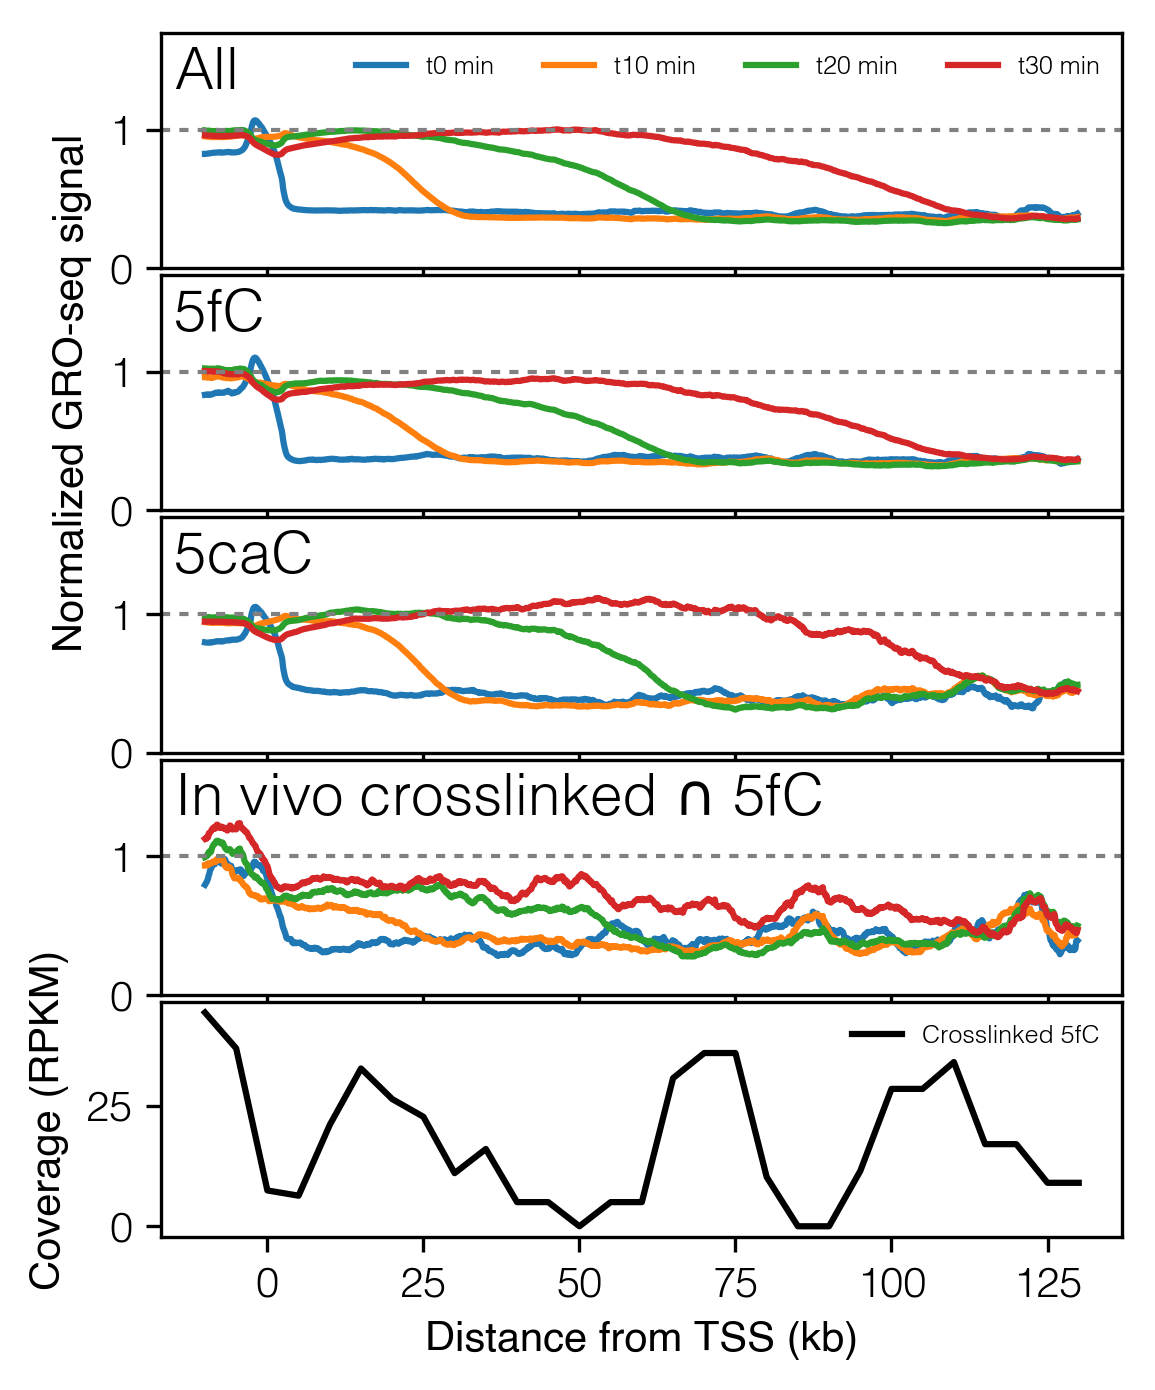

In [30]:
datasets = [All, fC_nocaC, caC_nofC, h3_ov5fC ]
names = ["All", "5fC", "5caC",
         "In vivo crosslinked $\cap$ 5fC"]
plot_profiles(datasets, ["t0", "t10", "t20", "t30", "std"], names, 
              h3_positions=smthed_h3_5fC_coverage, figname="main_figure_groseq_normalized_to_std.pdf")

____
We include all the subsets (5fC without no 5caC, etc.) for the supporting material

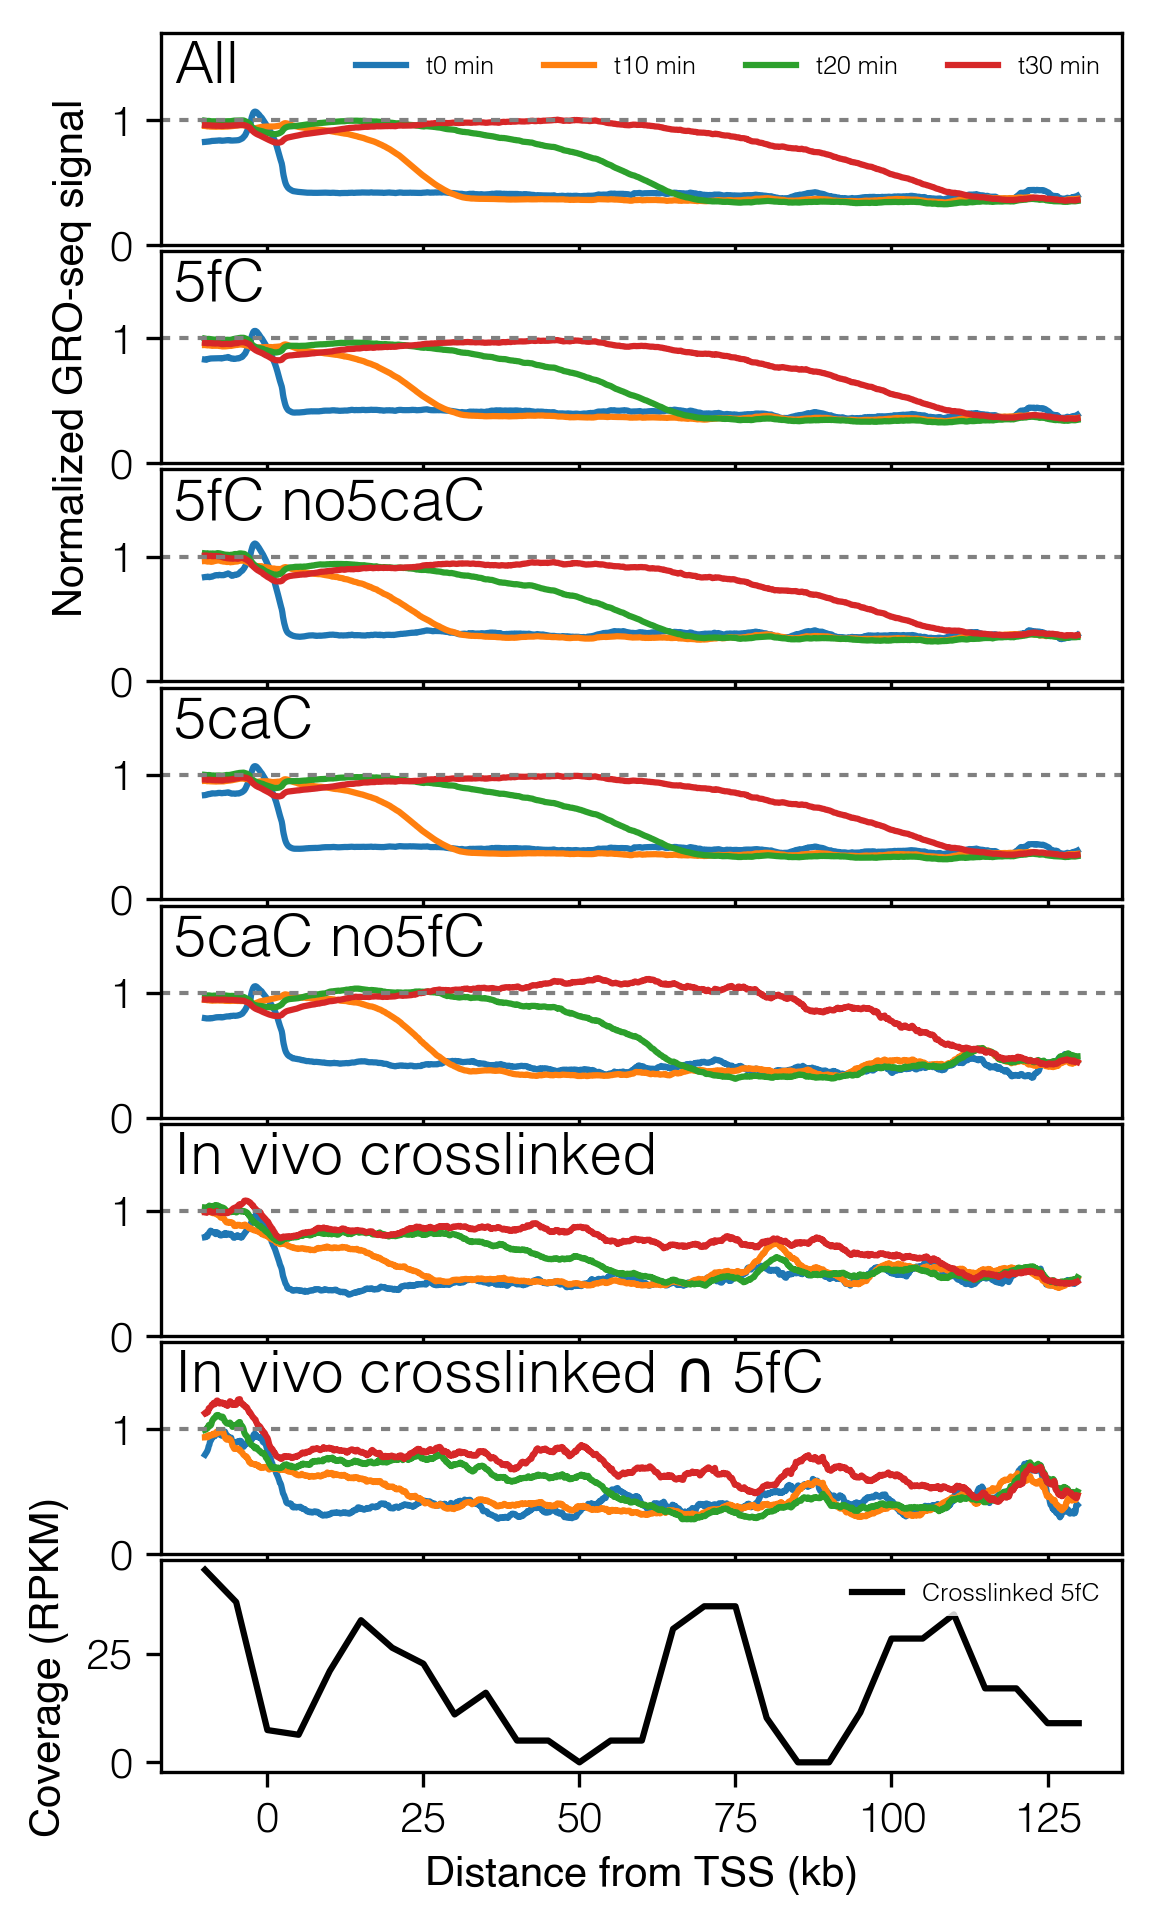

In [9]:
datasets = [All, fC, fC_nocaC, caC, caC_nofC, h3, h3_ov5fC ]
names = ["All", "5fC", "5fC no5caC",  "5caC", "5caC no5fC", "In vivo crosslinked",
         "In vivo crosslinked $\cap$ 5fC"]
plot_profiles(datasets, ["t0", "t10", "t20", "t30", "std"], names, h3_positions=smthed_h3_5fC_coverage, figw=10.5, figh=19.5, figname="suppl_figure_groseq_normalized_to_std.pdf")

----
### Plot the GRO-seq coverage around 5fC sites

Average fwd and rev strands, smooth a little 


In [10]:
def average_around_5fC(fn, list_time=["t10", "t20", "t30"], sg_window=21):
    """Return smoothed profiles and location of pol2 midpoint"""
    table = pd.read_table(fn)
    df = table.T 
    df.columns = df.iloc[0].values
    ####

    if sg_window % 2 == 0:
        print("SG smoothing window must be an odd number")
        return(None)
    
    if sg_window == 1:
        sg_pol = 0 
    else:
        sg_pol = 1
    
    l_w = list_time
        
    # Average both fwd and rev strands
    df_s = pd.DataFrame()
    for l in l_w + ["t0", "std"]:
        df_s[l]= 0.5*(df[l+"_r"][3:] + df[l+"_f"][3:])

    sm = {}
    data = sg_smooth(df_s["t0"], sg_window, sg_pol)
    sm.setdefault("t0", data)

    for l in l_w:
        data = sg_smooth(df_s[l], sg_window, sg_pol)
        sm.setdefault(l, data)

    data = sg_smooth(df_s["std"], sg_window, sg_pol)
    sm.setdefault("std", data)

    return(sm)

Define how to plot the data

In [11]:
def plot_around_5fC(d_res, time, names, scale_min=0, scale_max=1.2, end_occ=10, bs=10, beg=25000, end=25000):
    """Make a figure"""
    num_plots = len(time)
    f, axis = plt.subplots(num_plots, 1, figsize=(cm2inch(15,8)), sharex=True, dpi=120)
    f.subplots_adjust(hspace=0.1)

    if num_plots == 1:
        axs = [axis]
    else:
        axs = axis
    c=0
    for t, ax in zip(time, axs):
        c += 1
        kkk = 0
        for p, name in zip(d_res, names):
            kkk += 1
            ko  = p[t]
            if kkk  == 1:
                ax.plot(0.01*np.arange(-int(beg/bs),len(ko[:-int(beg/bs)])), ko, label=name, alpha=0.8, color="C8")
            else:
                ax.plot(0.01*np.arange(-int(beg/bs),len(ko[:-int(beg/bs)])), ko, label=name, alpha=0.8)
            ax.set_ylim(scale_min, scale_max)

        if c==1:
            ax.legend(ncol=2, fontsize=12, loc="upper left").get_frame().set_linewidth(0.1)

        if c==1:
            ax.set_ylabel("Coverage (RPKM)")
    
    plt.xlabel("Distance from 5fC (kb)")
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.savefig("groseq_coverage_around_5fC.pdf", bbox_inches='tight')
    plt.show()    

In [12]:
#smoothing window
window=21
# read in the data, average and smooth
fC_nocaC = average_around_5fC("around5fC_tss_wang_ko_5fC_no5caC.dat", 
                         list_time=["t10", "t20", "t30"], sg_window=window)
h3_ov5fC = average_around_5fC("around5fC_tss_wang_h3_1_3_overlap5fC.dat", 
                         list_time=["t10", "t20", "t30"], sg_window=window)

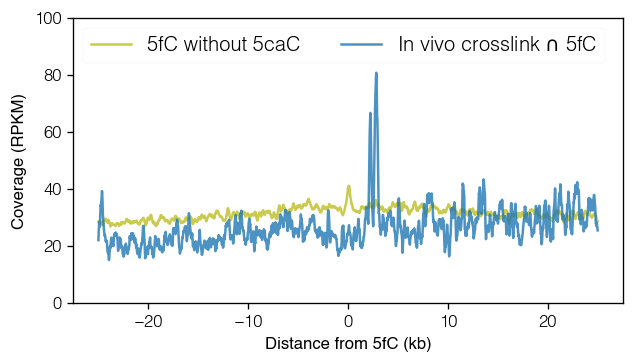

In [14]:
# which datasets to plot, and which names
datasets = [  fC_nocaC, h3_ov5fC]
names = [  "5fC without 5caC" , "In vivo crosslink $\cap$ 5fC"]
# finally plot the figure
plot_around_5fC(datasets, ["std"], names, scale_max=100, end_occ=0)

----